In [1]:

import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import random

In [5]:
results_folders=['R:\\Denoising\\Nilay\\murine_epithelial_data\\v73_mat_files']

In [6]:
def normalize(image, p_min=2, p_max=99.9, dtype='float32'):
    '''
    Normalizes the image intensity so that the `p_min`-th and the `p_max`-th
    percentiles are converted to 0 and 1 respectively.
    References
    ----------
    Content-Aware Image Restoration: Pushing the Limits of Fluorescence
    Microscopy
    https://doi.org/10.1038/s41592-018-0216-7
    '''
    low, high = np.percentile(image, (p_min, p_max))
    return (image - low) / (high - low + 1e-6)

def patch_image(image):
    '''Image should be 512x512'''
    return image.reshape(2, 256, 2, 256).swapaxes(1, 2).reshape(4, 256, 256)

def stitch_image(image):
    '''Image should be 4x256x256'''
    return np.reshape(image,[2, -1, 256, 256]).swapaxes(1,2).reshape(512, 512)

def create_patches(input,start,end):
    start = int(start)
    end = int(end)
    indices = list(range(start,end+1))
    total_patches = []
    for i in indices:
        image = input[i]
        image = np.transpose(image)
        image = normalize(image,2,99.9)
        patches = patch_image(image)
        total_patches.append(patches)
    total_patches = np.reshape(total_patches,(-1,256,256))
    return list(total_patches)

def Patchify(f,roi_name):
    try: 
        start_stack = f['stack_begin'][0]-1
        end_stack = f['stack_end'][0]-1
        FAD= f['fad_frames_512_shifted']
        NADH= f['nadh_frames_512_shifted']
        stack_num = end_stack - start_stack + 1
        assert stack_num > 0
        low_SNR_NADH = create_patches(NADH[3],start_stack,end_stack)
        high_SNR_NADH = create_patches(np.mean(NADH, axis=0),start_stack,end_stack)
        low_SNR_FAD = create_patches(FAD[3],start_stack,end_stack)
        high_SNR_FAD = create_patches(np.mean(FAD, axis=0),start_stack,end_stack)
        print('Start and end found: ' + roi_name + ": images=" + str(stack_num))
        return low_SNR_NADH , high_SNR_NADH, low_SNR_FAD, high_SNR_FAD, stack_num
    except:
        print('Data was not processed: ' + roi_name)
        return [],[],[],[],[]
        

In [7]:
size=512
X_N = []
X_F = []
Y_N = []
Y_F = []
start_list = []
end_list = []
key_names = []
ROI_counter = 0
stack_count = 0
for result_folder in results_folders:
    roi_mats = []
    os.chdir(result_folder)
    experiment_files = os.listdir()
    for experiment_file in experiment_files:
        if experiment_file.endswith('.mat'):
            roi_mats.append(experiment_file)
    for roi in roi_mats:
        roi_name = roi[0:-4]
        f= h5py.File(roi)
        low_SNR_NADH , high_SNR_NADH, low_SNR_FAD, high_SNR_FAD, stack_num = Patchify(f,roi_name)
        if len(low_SNR_NADH) > 0:
            key_names.append(roi_name)
            X_N.append(low_SNR_NADH)
            Y_N.append(high_SNR_NADH)
            X_F.append(low_SNR_FAD)
            Y_F.append(high_SNR_FAD)
            ROI_counter += 1
            start_list.append(int(stack_count*4))
            stack_count += stack_num 
            end_list.append(int(stack_count*4-1))
print('done')

Start and end found: 20210420_MouseCheek_ROI2_40X_denoising: images=[23.]
Start and end found: 20210420_MouseCheek_ROI3_40X_denoising: images=[19.]
Start and end found: 20210421_MouseCheek_ROI4_40X_denoising: images=[28.]
Start and end found: 20210421_MouseCheek_ROI5_40X_denoising: images=[20.]
Start and end found: 20210426_RatCheek_ROI1_40X_denoising: images=[26.]
Start and end found: 20210426_RatCheek_ROI2_40X_denoising: images=[12.]
Start and end found: 20210426_RatCheek_ROI3_40X_denoising: images=[14.]
Start and end found: 20210426_RatCheek_ROI4_40X_denoising: images=[14.]
Start and end found: 20210505_MouseCheek_ROI1_40X_denoising: images=[13.]
Start and end found: 20210505_MouseCheek_ROI2_40X_denoising: images=[30.]
Start and end found: 20210505_MouseCheek_ROI3_40X_denoising: images=[15.]
Start and end found: 20210505_MouseCheek_ROI4_40X_denoising: images=[8.]
Start and end found: 20210615_RatCheek_ROI1_40X_denoising: images=[31.]
done


In [8]:
# Seed here is constant as we only ever want to generate ONE identical Training and Test Set
ROIs = ROI_counter
testing_split = ROIs
random.seed(0) 
Training_idx = sorted(random.sample(range(0,ROIs), ROIs-testing_split))
Training_idx = [int(x) for x in Training_idx]
Testing_idx = sorted([x for x in list(range(0,ROIs)) if x not in Training_idx])

In [9]:
key_names = np.array(key_names)
start_list = np.array(start_list)
end_list = np.array(end_list)
X_N, X_F, Y_N, Y_F = np.array(X_N, dtype=object), np.array(X_F, dtype=object), np.array(Y_N, dtype=object), np.array(Y_F,dtype=object)

In [10]:
key_names_train = key_names[Training_idx]
start_list_train = start_list[Training_idx]
end_list_train = end_list[Training_idx]
X_N_train = X_N[Training_idx]
Y_N_train = Y_N[Training_idx]
X_F_train = X_F[Training_idx]
Y_F_train = Y_F[Training_idx]

key_names_test = key_names[Testing_idx]
start_list_test = start_list[Testing_idx]
end_list_test = end_list[Testing_idx]
X_N_test = X_N[Testing_idx]
Y_N_test= Y_N[Testing_idx]
X_F_test = X_F[Testing_idx]
Y_F_test = Y_F[Testing_idx]

In [30]:
# Training Set Saving
ROI_keys = [key[:(key.find('ROI')+4)] for key in key_names_train]
stack_begin = [item for item in start_list_train]
stack_end = [item for item in end_list_train]
X_n = [item for sublist in X_N_train for item in sublist]
Y_n = [item for sublist in Y_N_train for item in sublist]
X_f = [item for sublist in X_F_train for item in sublist]
Y_f = [item for sublist in Y_F_train for item in sublist]

In [49]:
np.savez('R:\\Cervical_Project\\Data\\NV_928_NADH_Training', X=X_n, Y=Y_n, SB=stack_begin, SE=stack_end, ROI_keys=ROI_keys)
np.savez('R:\\Cervical_Project\\Data\\NV_928_FAD_Training', X=X_f, Y=Y_f, SB=stack_begin, SE=stack_end, ROI_keys=ROI_keys)

In [13]:
# Testing Set Saving
ROI_keys = [key[:(key.find('ROI')+4)] for key in key_names_test]
stack_begin = [item for item in start_list_test]
stack_end = [item for item in end_list_test]
X_n = [item for sublist in X_N_test for item in sublist]
Y_n = [item for sublist in Y_N_test for item in sublist]
X_f = [item for sublist in X_F_test for item in sublist]
Y_f = [item for sublist in Y_F_test for item in sublist]

In [14]:
np.savez('R:\\Cervical_Project\\Data\\NV_Murine_NADH_Testing', X=X_n, Y=Y_n, SB=stack_begin, SE=stack_end, ROI_keys=ROI_keys)
np.savez('R:\\Cervical_Project\\Data\\NV_Murine_FAD_Testing', X=X_f, Y=Y_f, SB=stack_begin, SE=stack_end, ROI_keys=ROI_keys)

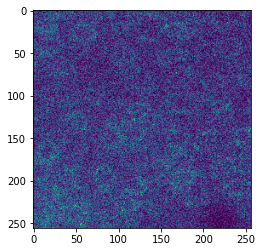

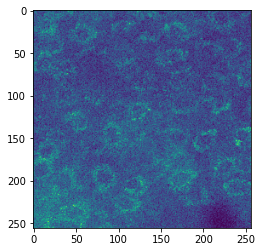

In [16]:
plt.imshow(X_n[1])
plt.figure()
plt.imshow(Y_n[1])

In [33]:
# Test set ROI names:
for i in ROI_keys:
    print(i)

20191121_Hysterectomy_ROI3
20200220_Hyterectomy_ROI1
20200928_Hysterectomy_ROI2
20201119_Hysterectomy_ROI1
20201127_Hysterectomy_ROI2
20201127_Hysterectomy_ROI4
20201214_Hysterectomy_ROI1
20201214_Hysterectomy_ROI2
20201214_Hysterectomy_ROI3
20210415_Hysterectomy_ROI1
20210415_Hysterectomy_ROI3
20210526_Hysterectomy_ROI1
20210526_Hysterectomy_ROI3
20201211_COLPO_ROI1
20201211_COLPO_ROI2
20201211_COLPO_ROI3
20201221_COLPO_ROI1
20201221_COLPO_ROI5
20210108_COLPO_ROI4
20210312_COLPO_ROI1
20210402_COLPO_ROI2
20210402_COLPO_ROI3
20210409_COLPO_ROI1
20210525_COLPO_ROI1
20210816_COLPO_ROI1
20210921_COLPO_ROI1
20211008_COLPO_ROI1
20200901_LEEP_ROI3
20200902_LEEP_ROI2
20200909_LEEP_ROI4
20210126_LEEP_ROI1
20210126_LEEP_ROI2
20210330_LEEP_ROI1
20210519_LEEP_ROI1
20210604_LEEP_ROI2
20210604_LEEP_ROI3
20210810_LEEP_ROI1
20210810_LEEP_ROI2
20210910_LEEP_ROI1
20210929_LEEP_ROI1
20210929_LEEP_ROI2
20211022_LEEP_ROI2
20211108_LEEP_ROI2
20211116_LEEP_ROI3
20211217_LEEP_ROI1
20211228_LEEP_ROI1
20211228_